# Neural Operators

Quinn Heng-Martin, Brandt Benfield; Colorado State University 2025

## Introduction

Neural Networks (NNs) are often described as universal function approximators, mapping an arbitrary set of inputs to outputs. This is certainly a very useful task, however in physics and engineering we are often interested in examining systems that produce different functions characterized by the same underlying behavior, depending on some initial or boundary conditions. It is the underlying behaviour we are interested in, not the particular function. That is, we seek to find mappings from functions to functions. This actually expands our problem space more than one might think: since there are an infinite number of functions that are completely unrelated (the family $\delta(x-x_0)$ for example), our parameter space is actually *infinite dimensional*. This might seem an insurmountable challenge, but NNs provide a nice starting point. This function-to-function mapping is precisely what an operator is, so a NN-derived architecture to solve these problems, naturally, is called a Neural Operator (NO). NOs were originally proposed by researchers at Caltech in 2020 [[1](https://arxiv.org/abs/2010.08895)] [[2](https://arxiv.org/abs/2108.08481)] - We seek to use the NO library published by the this team ([arxiv](https://arxiv.org/abs/2412.10354)) to create short- to medium-term weather forecasts for Colorado (a conveniently rectangular state).

### On the Technical Details
Neural operators(NO) take an input function a(x) and transforms it through a series of lifting layers, followed by T Fourier layers, then a projection layer, ultimately outputting the solution function u(x). This sequential processing allows the NO to learn the mapping between infinite-dimensional function spaces.[[2](https://arxiv.org/pdf/2108.08481)]

The internal structure of a single Fourier layer is as so. It receives an input function v(x). The core of the Fourier layer lies in its application of the Fourier transform (F) to the input, moving the function from the physical space to the Fourier space. In this spectral domain the different frequency modes of the function are represented. A linear operation with a filter kernel is then performed. This operation allows the network to selectively modify or emphasize certain frequency components. Subsequently, an inverse Fourier transform (inv(f)) brings the processed function back to the physical space. In parallel to this spectral pathway, the input function v(x) also undergoes a point-wise linear transformation. The outputs of the spectral pathway (after the inverse Fourier transform) and the point-wise transformation are then added together. Finally, a non-linear activation function σ is applied to the summed result preparing the output for the next layer in the sequence. By stacking multiple such Fourier layers the FNO can learn complex mappings between function spaces. Making it particularly effective for solving partial differential equations and other tasks involving continuous functions. The key innovation of FNOs lies in performing the integral operator in the Fourier domain through efficient element-wise multiplication. Which can be implemented using Fast Fourier Transforms, leading to computational efficiency and the ability to handle high-dimensional input and output spaces.[[2](https://arxiv.org/pdf/2108.08481)]


### The Gameplan (Methodology):

The project utilizes historical weather data to train and evaluate machine learning models for forecasting purposes. All training data is sourced from the ERA5 dataset. Specifically the "ERA5 hourly data on single levels from 1940 to present," provided by the European Centre for Medium-Range Weather Forecasts (ECMWF). This dataset offers comprehensive high-resolution atmospheric reanalysis data that captures hourly weather variables across multiple decades.

To ensure compatibility with the machine learning pipeline and to meet project submission requirements the ERA5 data is preprocessed and converted into CSV format. This format enhances accessibility, facilitates data exploration, and simplifies integration with common data science tools and environments.

Subsequent stages of the methodology include:

In [ ]:
# Neural Operator install Options:
#!pip install neuraloperator
#!pip install git+https://github.com/neuraloperator/neuraloperator.git
#!conda install conda-forge::neuraloperator

from neuralop.training import Trainer
from neuralop.models import FNO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation
class WeatherTensorDataset(Dataset):          # This class is a custom dataset loader that will load preprocessed
    def __init__(self, data_path):            # weather data (saved as a .pt file) into PyTorch’s data pipeline.
        self.samples = torch.load(data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return {'x': self.samples[idx][0], 'y': self.samples[idx][1]}

First, let's load up our data and get a look at it:

,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
0,2022-01-01 03:00:00,41.0,-109.0,0.694458,-0.103119,-12.12968,-10.70420,77215.0,0.223984,0.018707
1,2022-01-01 03:00:00,41.0,-108.5,0.498169,0.364655,-12.65702,-11.20420,77910.0,0.170273,0.116364
2,2022-01-01 03:00:00,41.0,-108.0,-0.283081,0.928131,-12.59843,-10.97373,77852.0,-0.130508,0.344879
3,2022-01-01 03:00:00,41.0,-107.5,-1.179565,1.212311,-13.98710,-11.95030,75851.0,-0.657852,0.766754
4,2022-01-01 03:00:00,41.0,-107.0,-0.895386,0.902740,-14.65116,-12.76670,73532.0,-0.682266,0.731598


,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
196932,2022-12-31 15:00:00,38.0,-103.0,3.524460,0.855179,-8.22397,0.75380,86111.625,3.335800,0.793854
77170,2022-05-23 21:00:00,38.5,-104.0,-1.738861,-3.943138,5.45767,16.50747,84794.625,-1.943131,-4.400206
190701,2022-12-20 03:00:00,38.5,-106.0,2.050384,-1.035141,-21.56037,-17.40288,73455.810,0.567413,-0.286163
16881,2022-02-01 09:00:00,41.0,-106.0,1.969177,0.469528,-15.04252,-12.79328,74028.690,1.161941,0.219696
2082,2022-01-04 21:00:00,39.5,-103.0,9.415131,-5.949570,-12.53110,13.00430,84885.690,9.459183,-5.976257


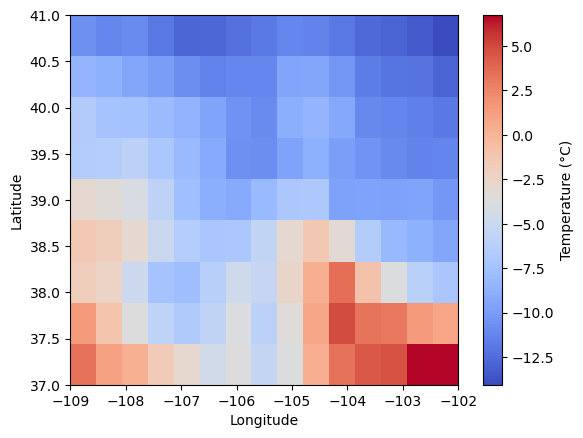

In [ ]:
df = pd.read_csv('data2022/accum_data.csv')
df.valid_time = df.valid_time.astype('datetime64[s]')
df[['surface_dewpoint', 'surface_temperature']] -= 273.15

W = len(df.longitude.unique())
H = len(df.latitude.unique())
T = len(df.valid_time.unique())
extent = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())

display(df.head())
display(df.sample(5))
initial_temp = (df[df.valid_time=='2022-01-01 3:00:00']
                .pivot(index='latitude',columns='longitude',
                       values='surface_temperature')
                .sort_index(ascending=False)
               )
def plot(data, label='Temperature (°C)', title=None):
  plt.imshow(data, aspect=W/H, extent=extent, cmap='coolwarm')  # or 'viridis' if you prefer
  plt.colorbar(label=label)
  if title:
      plt.title(title)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

plot(initial_temp)

Nice! next up, a neural operator should benefit from knowing the coordinates of it's data, including time. Let's make a float-valued time that a NO can understand:

In [ ]:
# Assign each time a timestep float
times = df['valid_time'].sort_values().unique()
dt = times[1]-times[0] # The model will see a day that is 24H/dt ticks long
df['time'] = (df['valid_time']-times[0])/dt
(times-times[0])/dt

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.457e+03, 1.458e+03,
       1.459e+03])

In [ ]:
# Re-package everything into 3d data

# Drop valid_time and move all coordinate channels to the end as the model expects: (there's definitely a more elegant way to do this..)
channels = list(df.columns.drop(['valid_time', 'latitude', 'longitude']))+['latitude','longitude']
C = len(channels)
data_array = (df[channels]
              .sort_values(['time', 'latitude', 'longitude'])
              .values
              .reshape([T,H,W,C])
             )
print(f'{data_array.shape = } = (T, H, W, C)')

data_array.shape = (1460, 9, 15, 10) = (T, H, W, C)


As a sanity check, let's show that inital temperature distribution again:

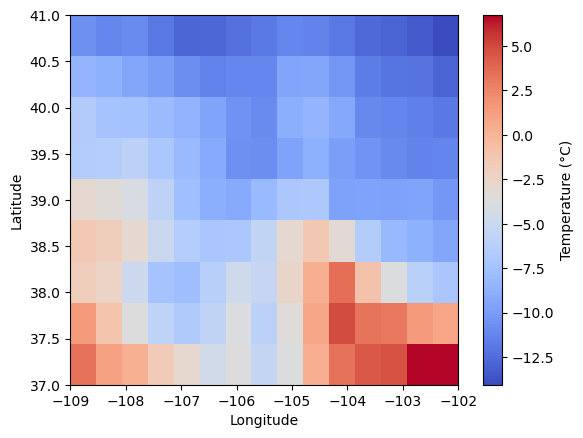

In [ ]:
plot(data_array[0,::-1,:,3])

Looking good!

In [ ]:
data = (torch.tensor(data_array, dtype=torch.float32)
        .transpose(0,3))  # Place channels up front to appease neuralop

## Experiment 1:
As a diagnostic before getting into heavier computation, let's see if the NO can predict the temperature distribution one timestep later:

In [ ]:
# Make some input/output pairs:

# TODO apparently i was thinking in two directions at some point, this needs looked at

data = data
input_tensor = data[:,:,:,:-1]
input_tensors = input_tensor.split(split_size=1,dim=3)

In [ ]:
#output_tensor = data[:,:,:,1:]  # Try to predict the next timestep
output_tensor = data[[3],:,:,1:]  # Just try to predict the next temp

In [ ]:
#output_tensors = output_tensor.split(split_size=1,dim=3)

# Split data into pairs of timesteps. Given one timestep, the model should predict the next one
from itertools import pairwise
#chunks = map(torch.squeeze, data.split(1,dim=3))
#chunks = tuple(pairwise(chunks))
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(1,dim=3)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(1,dim=3))))
print(f'{chunks[0][1].shape = }')
torch.save(chunks, 'weather_chunks.pt')
tuple(pairwise(torch.tensor((1,2,3,4,5,6)).split(1, dim=0)))  # Illustration of split and pairwise working together

chunks[0][1].shape = torch.Size([1, 9, 15])


((tensor([1]), tensor([2])),
 (tensor([2]), tensor([3])),
 (tensor([3]), tensor([4])),
 (tensor([4]), tensor([5])),
 (tensor([5]), tensor([6])))

In [ ]:
'''
# Load and clean the CSV file
df = pd.read_csv('accum_data.csv')

# Grid creation
times = sorted(df['valid_time'].unique()) # Get unique times

input_vars = ['u10', 'v10', 'surface_pressure', 'u10n', 'v10n']
output_var = 'surface_temperature'

grids = []

lat_vals = sorted(df['latitude'].unique()) # Unique lat
lon_vals = sorted(df['longitude'].unique()) # Unique long

H = len(lat_vals) # Height (number of latitude values)
W = len(lon_vals)  # Width (number of longitude values)

# Process the data for each time step
for time in tqdm(times):   # tqdm(times) progress bar for visualization
    slice_df = df[df['valid_time'] == time] # Get data for the current time step


    # Build 2D grid for each input variable
    input_channels = [slice_df
                      .pivot(index='latitude', columns='longitude', values=var)
                      .to_numpy()
                      for var in input_vars
                     ]
    # for var in input_vars:
    #     pivot = slice_df.pivot(index='latitude', columns='longitude', values=var)
    #     grid = pivot.to_numpy() # Creates a 2D grid using pandas
    #     input_channels.append(grid)

    # Build target grid
    target_pivot = slice_df.pivot(index='latitude', columns='longitude', values=output_var)
    target_grid = target_pivot.to_numpy()

    # Stack into tensors
    input_tensor = torch.tensor(np.stack(input_channels), dtype=torch.float32)  # Shape: [C, H, W]  (C is the # of input variables, H is the # of lat points, and W is the # of long points)
    target_tensor = torch.tensor(target_grid[np.newaxis, :, :], dtype=torch.float32)  # Shape: [1, H, W]

    grids.append((input_tensor, target_tensor))

# Save the dataset to a file
torch.save(grids, 'weather_dataset.pt')  # List of (input, target) pairs
'''
None

In [ ]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_dataset.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = 5 # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=2, device=device)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}
full_dataset[0]['x'].shape, full_dataset[0]['y'].shape

(torch.Size([5, 9, 15]), torch.Size([1, 9, 15]))

In [ ]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_chunks.pt')
full_dataset[0]['x'].shape

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = C # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, device=device, eval_interval=1, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

In [ ]:
train_dataset[0]['x'].shape, train_dataset[0]['y'].shape

(torch.Size([10, 9, 15]), torch.Size([1, 9, 15]))

In [ ]:
# Train the model
trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 1167 samples
Testing on [292] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([4, 1, 9, 15])
[0] time=18.67, avg_loss=3.8105, train_err=15.2291
Eval: test_l2=1.3104
[1] time=15.37, avg_loss=1.8070, train_err=7.2218
Eval: test_l2=0.9767
[2] time=14.04, avg_loss=1.0876, train_err=4.3467
Eval: test_l2=1.1935
[3] time=13.26, avg_loss=1.0296, train_err=4.1147
Eval: test_l2=1.0396
[4] time=12.92, avg_loss=0.9294, train_err=3.7143
Eval: test_l2=0.8692
[5] time=12.90, avg_loss=0.8635, train_err=3.4511
Eval: test_l2=0.8647
[6] time=12.74, avg_loss=0.8538, train_err=3.4123
Eval: test_l2=0.8628
[7] time=12.97, avg_loss=0.8574, train_err=3.4268
Eval: test_l2=0.8660
[8] time=12.96, avg_loss=0.8581, train_err=3.4294
Eval: test_l2=0.8602
[9] time=12.80, avg_loss=0.8660, train_err=3.4609
Eval: test_l2=0.8589


{'train_err': 3.4609032746863693,
 'avg_loss': 0.8659672289703683,
 'avg_lasso_loss': None,
 'epoch_train_time': 12.803975187000106,
 'test_l2': tensor(0.8589)}

Strangely, I only get this NNPACK! warning occasionally. It seems to lead to about a 3x slowdown. Painful, considering how long training is taking already...

Looking at the losses, it looks like we really only needed a couple of epochs to train! (the error usually off pretty early, and the loss falls off early if ever) So how's it look?

[W508 23:06:56.839303107 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


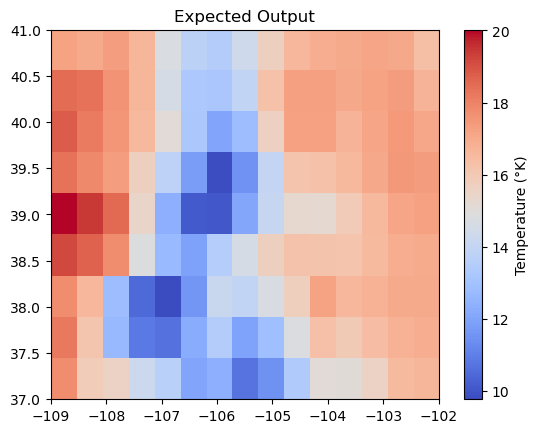

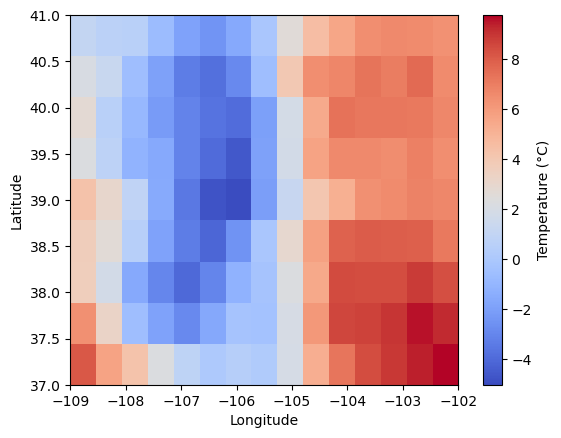

In [ ]:
x_example = test_dataset[73]['x'].unsqueeze(0)
y_expected = test_dataset[73]['y']
y_predicted = model(x_example)

plt.imshow(y_expected.squeeze().numpy()[::-1,:], cmap='coolwarm', aspect=W/H, extent=extent)
plt.colorbar(label='Temperature (°C)')
plt.title('Expected Output')
plt.show()

plot(y_predicted.squeeze().detach().numpy()[::-1,:])
plt.show()

In [ ]:
%timeit y_predicted = model(x_example)

8.38 ms ± 91.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not terrible... let's crank it up!

## Experiment two:

Can the default FNO predict all of the channels we're feeding into it?

In [ ]:
# Dataset Splitting

ticks_per_group = 4

input_tensor = data[:,:,:,:-ticks_per_group]
output_tensor = data[:-3,:,:,ticks_per_group:]  # Try to predict all variables at the next timestep

time_dim = 3
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(ticks_per_group, dim=time_dim)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(ticks_per_group, dim=time_dim))))
torch.save(chunks, 'weather_chunks2.pt')
full_dataset = WeatherTensorDataset('weather_chunks2.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

train_dataset[0]['y'].shape # C x T x H x W, where T is the number of observation times

torch.Size([7, 9, 15, 4])

In [ ]:
# Model Setup

in_channels = train_dataset[0]['x'].shape[0] # # of input
out_channels = train_dataset[0]['y'].shape[0] # # of output

# Initialize the model
model = FNO(n_modes=(12, 12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, eval_interval=1, device=device, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 291 samples
Testing on [73] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([5, 7, 9, 15, 4])
[0] time=12.78, avg_loss=898.4069, train_err=4431.1256
Eval: test_l2=303.2675
[1] time=13.07, avg_loss=124.2118, train_err=612.6381
Eval: test_l2=113.9029
[2] time=12.84, avg_loss=120.9400, train_err=596.5008
Eval: test_l2=207.9104
[3] time=12.96, avg_loss=139.6884, train_err=688.9714
Eval: test_l2=193.3253
[4] time=13.25, avg_loss=100.0079, train_err=493.2592
Eval: test_l2=115.4041
[5] time=13.26, avg_loss=84.5531, train_err=417.0330
Eval: test_l2=139.6015
[6] time=13.46, avg_loss=87.4188, train_err=431.1675
Eval: test_l2=81.6253
[7] time=15.06, avg_loss=72.8641, train_err=359.3806
Eval: test_l2=103.0616
[8] time=13.10, avg_loss=71.5623, train_err=352.9600
Eval: test_l2=72.9507
[9] time=13.32, avg_loss=66.4191, train_err=327.5926
Eval: test_l2=66.0679


{'train_err': 327.59263067730404,
 'avg_loss': 66.41912443285545,
 'avg_lasso_loss': None,
 'epoch_train_time': 13.322737434998999,
 'test_l2': tensor(66.0679)}

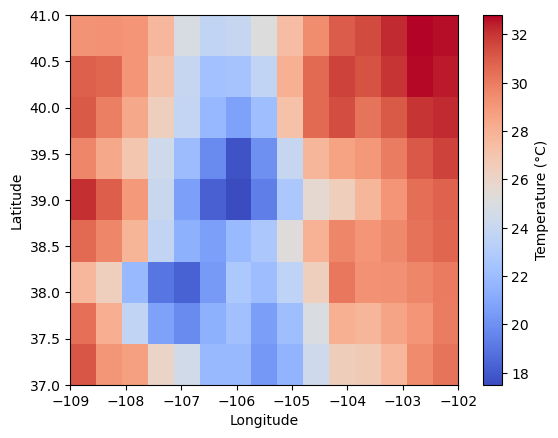

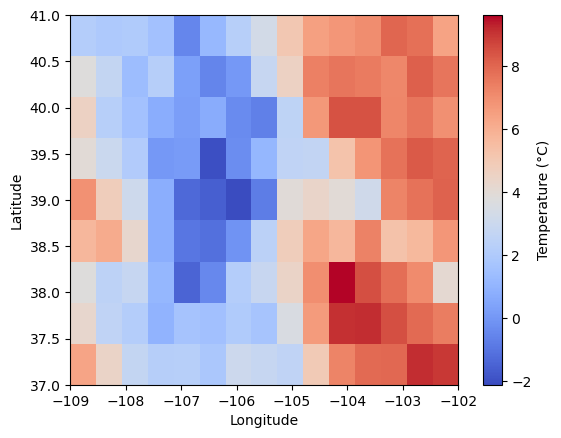

In [ ]:
look_at=42
x_example = test_dataset[look_at]['x'].unsqueeze(0)
y_expected = test_dataset[look_at]['y'][:,:,:,ticks_per_group-1]
plot(y_expected.numpy()[3,::-1,:])
y_predicted = model(x_example).squeeze().detach().numpy()[:,:,:,ticks_per_group-1]
plot(y_predicted[3,::-1,:])

Well that's worse...but not much worse (usually)! Let's look at the rest of the channels:

i = 0


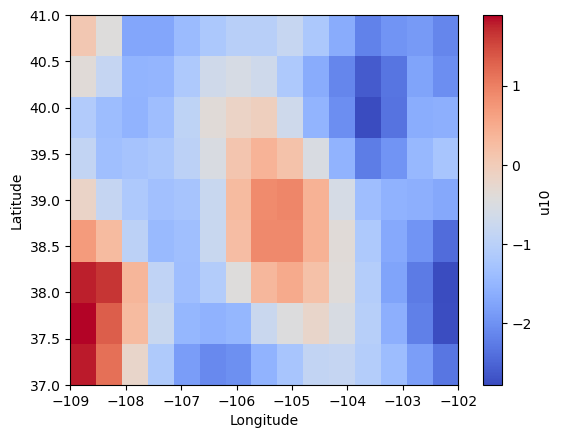

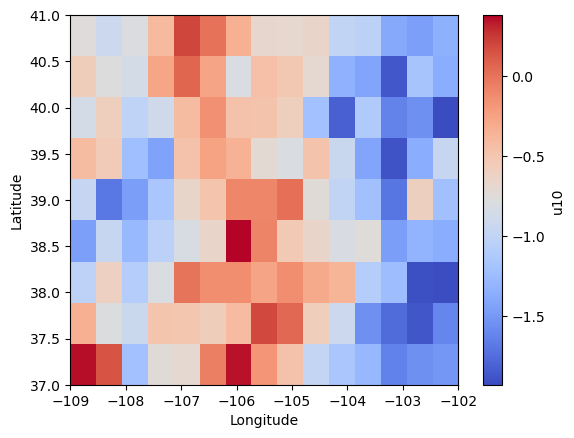

i = 1


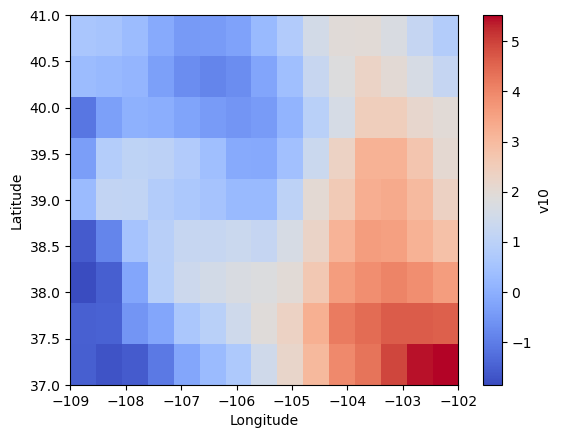

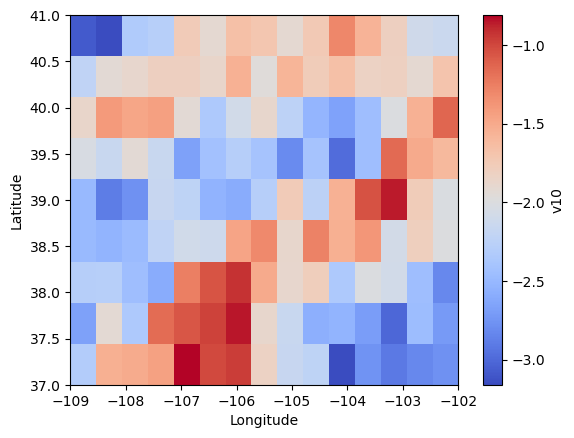

i = 2


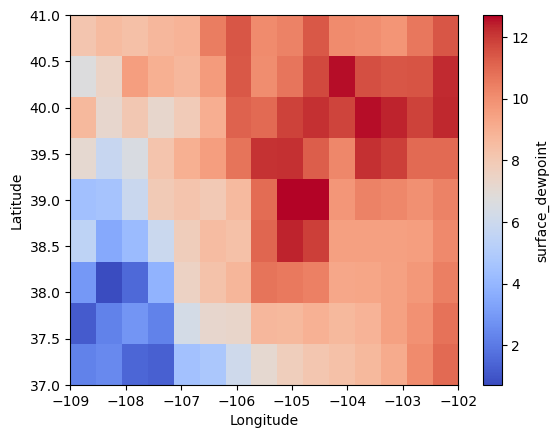

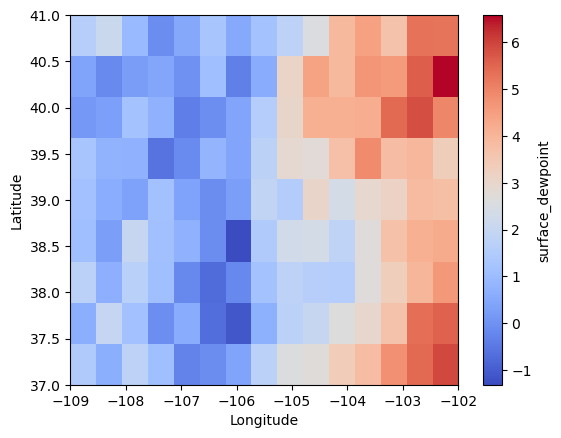

i = 3


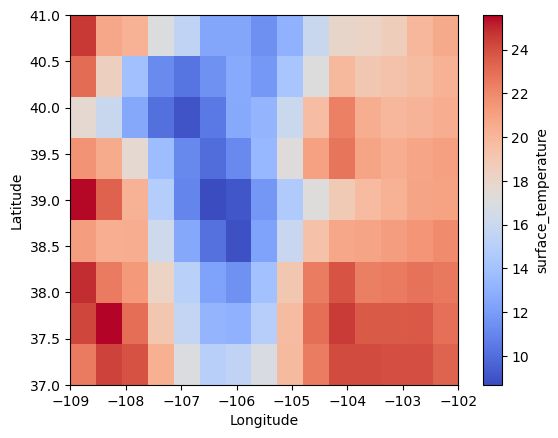

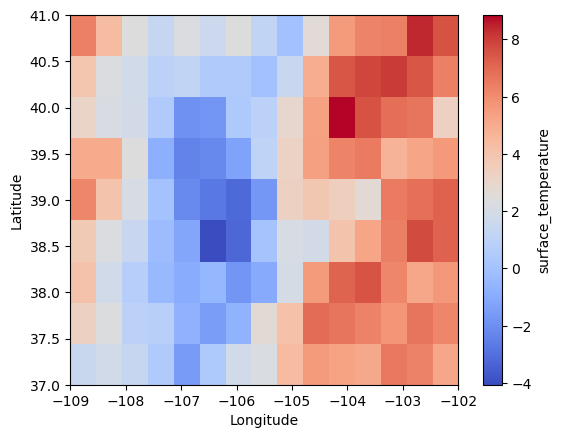

i = 4


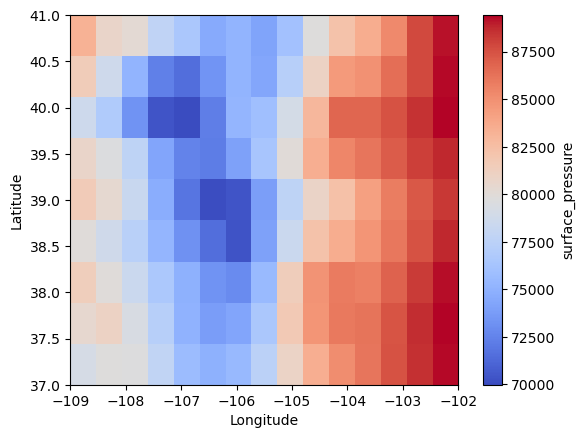

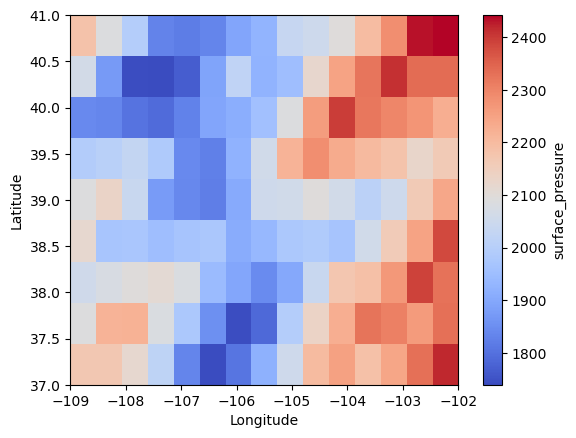

i = 5


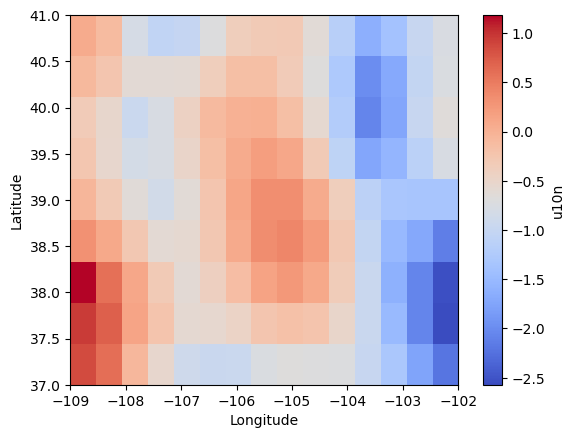

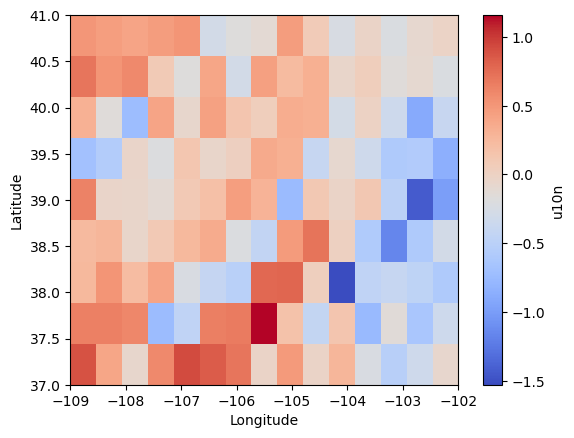

i = 6


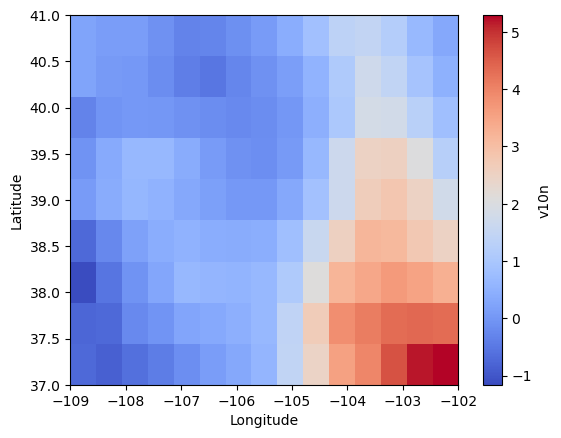

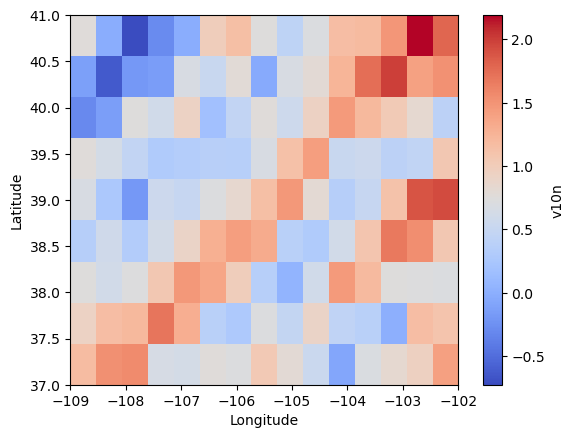

In [ ]:
out = model(test_dataset[look_at]['x'].unsqueeze(0)).squeeze()
for i in range(out.shape[0]):
    print(f'{i = }')
    expected = test_dataset[look_at]['y'][i,:,:,0]#ticks_per_group-1]
    prediction = out[i,:,:,0]#ticks_per_group-1]
    plot(expected, label=channels[i])
    plot(prediction.detach().numpy(), label=channels[i])

In [ ]:
%timeit y_predicted = model(x_example)

17.2 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Well... it's got the spirit at least...

## Appendix: Data Conversion




In [ ]:
#please don't remove I need them every time I pull from main
#!apt-get install -y libeccodes0 libeccodes-dev
#!pip install cfgrib xarray

In [ ]:
import xarray as xr

# Load GRIB (or grb) file (from what I found they act the same)
ds = xr.open_dataset('CaribbeanWeatherTest.wind.7days.grb', engine='cfgrib')

# Inspect the dataset
print(ds)
ds.variables.keys()

In [ ]:
# For example, if 'time' is a variable:
time = ds['time']
print(time)

## Reflection

Experiment 1 successfully demonstrated that the default FNO model is capable of learning to predict the surface temperature at the next timestep with reasonable accuracy. After only a few epochs the loss and training error rapidly decreased and evaluation L2 errors stabilized around 0.86, indicating the model's ability to capture short-term temporal dependencies. Notably, most of the training benefit occurred within the first few epochs suggesting that either the model architecture is overparameterized for this specific prediction task or that the data was relatively easy to fit.

Visually, the predicted temperature fields resembled the expected outputs quite well and inference was reasonably fast averaging around 8.38 ms per forward pass. However, intermittent warnings about NNPACK support were observed leading to performance slowdowns that should be further investigated, particularly for deployment or longer training sessions.

Experiment 2 expanded the complexity by attempting to predict all target channels across multiple timesteps. This significantly increased both the input/output dimensionality and the difficulty of the task. Initial results showed very high training loss (avg_loss ≈ 898) and evaluation L2 errors (test_l2 ≈ 303), suggesting the model struggled with the more complex temporal and multivariate relationships. This could stem from several factors, including:

Insufficient number of training epochs to converge on this more difficult problem.

Inadequate model capacity or missing architectural components for modeling long-range or multi-channel dependencies.

Potential misalignment in time dimension handling when slicing the data for the experiment.

#Things that could be inproved:

Data augmentation or longer training might help stabilize training for Experiment 2.

Consider testing temporal convolutions, sequence modeling (e.g., Transformers or RNN layers), or FNO variants with improved temporal structure.

Explore normalization of input/output tensors to reduce scale discrepancies that may lead to large initial losses.

Overall, the diagnostics showed promise for FNOs in weather modeling, with good results in simpler settings and clear directions for improvement in more complex scenarios.




